In [ ]:
# Forecasting the Breeding Bird Survey

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from macroecotools import richness_in_group, abundance_in_group, obs_pred_rsquare
from bbs_benchmarks import get_data, filter_timeseries, benchmark_predictions, mape

In [2]:
%matplotlib inline

## Initial data setup

In [3]:
bbs_data = get_data('bbs')
bbs_comm_timeseries = filter_timeseries(bbs_data, ['site_id'], 'year', 10)

## Richness Analysis

In [4]:
richness = richness_in_group(bbs_comm_timeseries, ['site_id', 'year'], ['species_id'])
richness_by_site = richness.groupby('site_id')

/home/ethan/anaconda/envs/forecasting/lib/python3.4/site-packages/macroecotools/macroecotools.py:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  composition_data['_spid'] = single_spid


In [5]:
forecast_data = []
for site, site_data in richness_by_site:
    for lag in range(1, 10):
        forecast_data.append([site, lag] + benchmark_predictions(site_data['year'], site_data['richness'], lag=lag))

forecast_data = pd.DataFrame(forecast_data, columns=['site', 'lag', 'last_yr_rich', 'lag_rich', 'avg_rich'])
forecast_data['forecast_error_avg'] = 100 * (forecast_data['last_yr_rich'] - forecast_data['avg_rich']) / forecast_data['last_yr_rich']
forecast_data['forecast_error_last_yr'] = 100 * (forecast_data['last_yr_rich'] - forecast_data['lag_rich']) / forecast_data['last_yr_rich']

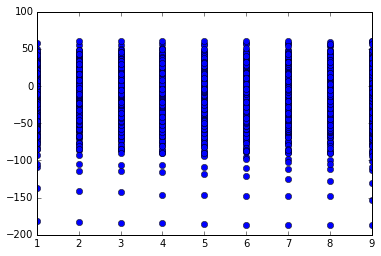

In [6]:
plt.plot(forecast_data['lag'], forecast_data['forecast_error_avg'], 'bo')

In [29]:
len(forecast_data)

32913

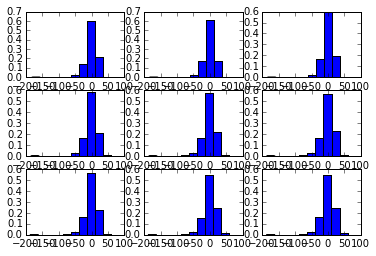

In [31]:
for lag in range(1, 10):
    plt.subplot(3,3,lag)
    lag_data = forecast_data[forecast_data['lag'] == lag]
    weights = np.ones_like(lag_data['forecast_error_avg'])/len(lag_data)
    plt.hist(np.array(lag_data['forecast_error_avg']), weights=weights)

In [7]:
by_lag = forecast_data.groupby('lag')
by_lag.apply(lambda x: mape(x['last_yr_rich'], x['avg_rich']))

lag
1    5.735794
2    5.905524
3    6.061333
4    6.205437
5    6.350035
6    6.483601
7    6.619655
8    6.757402
9    6.917970
dtype: float64

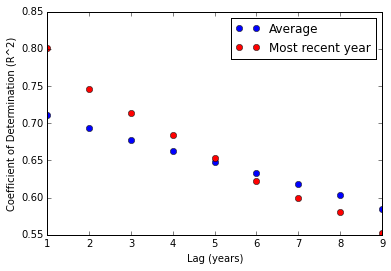

In [5]:
coefdets_avg_rich = []
coefdets_lag_rich = []
lags = []
for lag in range(1, 10):
    lags.append(lag)
    lag_data = forecast_data[forecast_data['lag'] == lag]
    coefdets_avg_rich.append(obs_pred_rsquare(lag_data['last_yr_rich'], lag_data['avg_rich']))
    coefdets_lag_rich.append(obs_pred_rsquare(lag_data['last_yr_rich'], lag_data['lag_rich']))

plt.plot(lags, coefdets_avg_rich, 'bo')
plt.plot(lags, coefdets_lag_rich, 'ro')
plt.xlabel('Lag (years)')
plt.ylabel('Coefficient of Determination (R^2)')
plt.legend(['Average', 'Most recent year',])

## Population Abundance Analysis

In [ ]:
bbs_pop_timeseries = filter_timeseries(bbs_data, ['site_id', 'species_id'], 'year', 10)
ab_by_pop = bbs_pop_timeseries.groupby(['site_id', 'species_id'])

forecast_data_pop = []
step = 1
for pop, pop_data in ab_by_pop:
    site_id, species_id = pop
    pop_data = pop_data.sort('year')
    last_yr_ab = pop_data['abundance'].iloc[-1]
    other_yrs_ab = pop_data['abundance'].iloc[:-1]
    prev_yr_ab = pop_data.sort('year')['abundance'].iloc[-2]
    avg_ab = np.mean(other_yrs_ab)
    forecast_data_pop.append([site_id, species_id, last_yr_ab, prev_yr_ab, avg_ab])
    step += 1
    if step % 1000 == 0:
        print(step / 200000.0)

forecast_data_pop = pd.DataFrame(forecast_data_pop, columns=['site_id', 'species_id', 'last_yr_ab', 'prev_yr_ab', 'avg_ab'])
coefdet_avg_ab = obs_pred_rsquare(forecast_data_pop['last_yr_ab'], forecast_data_pop['avg_ab'])
coefdet_prev_yr_ab = obs_pred_rsquare(forecast_data_pop['last_yr_ab'], forecast_data_pop['prev_yr_ab'])